# Import libraries

In [54]:
import os
import tarfile
import urllib
import urllib.request
import pandas as pd
import numpy as np
from zlib import crc32
import joblib
from scipy.stats import randint

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from scipy import stats


import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

%matplotlib inline

In [55]:
#os.chdir("/content/drive/My Drive/hands-on-ml")
%ls

datasets/  sample_data/


# Load the Data Set

In [56]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = os.path.join(DOWNLOAD_ROOT, HOUSING_PATH+"/housing.tgz")

In [57]:
def fetch_housing_data():
    os.makedirs(HOUSING_PATH, exist_ok=True)
    tgz_path = os.path.join(HOUSING_PATH, "housing.tgz")
    urllib.request.urlretrieve(HOUSING_URL, filename=tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=HOUSING_PATH)
    housing_tgz.close()


def load_housing_data():
    csv_path = os.path.join(HOUSING_PATH, "housing.csv")
    return pd.read_csv(csv_path)

In [58]:
fetch_housing_data()

In [59]:
housing_df = load_housing_data()

housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# Exploratory Data Analysis - EDA

In [60]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [61]:
housing_df["ocean_proximity"].value_counts()

,count
ocean_proximity,
<1H OCEAN,9136
INLAND,6551
NEAR OCEAN,2658
NEAR BAY,2290
ISLAND,5


In [62]:
housing_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

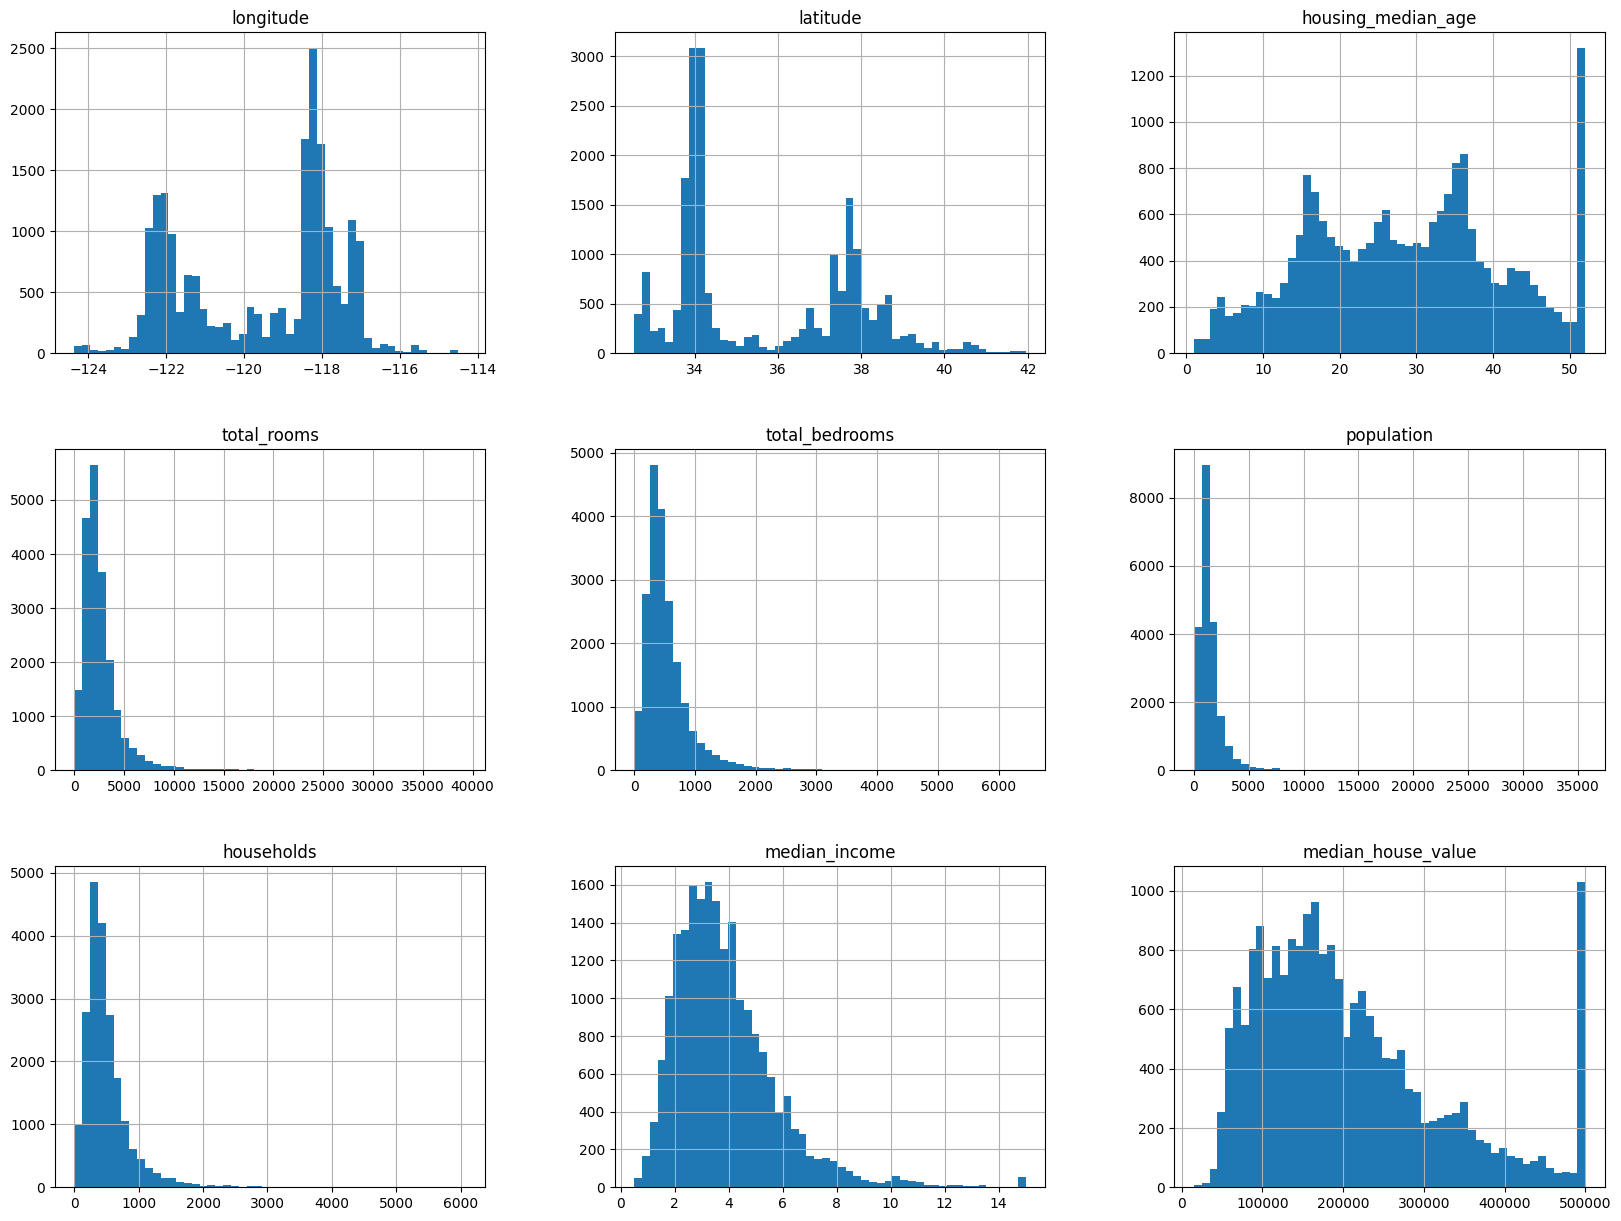

In [63]:
housing_df.hist(bins=50, figsize=(20, 15))

**Create a test set and neve look at it.**

In [64]:
def split_train_test(data, test_ratio):
    shuffle_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffle_indices[:test_set_size]
    train_indices = shuffle_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]


def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2 ** 32


def split_train_test_by(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[-in_test_set], data.loc[in_test_set]

In [65]:
np.random.seed(42)
train_set, test_set = split_train_test(housing_df, 0.2)

print(f"Amount of train dataset: {len(train_set)}")
print(f"Amount of test dataset: {len(test_set)}")

Amount of train dataset: 16512
Amount of test dataset: 4128


In [66]:
housing_with_id = housing_df.reset_index()
train_set, test_set = split_train_test_by(housing_with_id, 0.2, "index")

In [67]:
housing_with_id["id"] = housing_df["longitude"] * 1000 + housing_df["latitude"]

train_set, test_set = split_train_test_by(housing_with_id, 0.2, "id")

# Preprocessing

In [68]:
housing_df["income_cat"] = pd.cut(housing_df["median_income"],
                                  bins=[0., 1.5, 3.0, 4.5, 6, np.inf],
                                  labels=[1, 2, 3, 4, 5])

In [69]:
housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3


<Axes: >

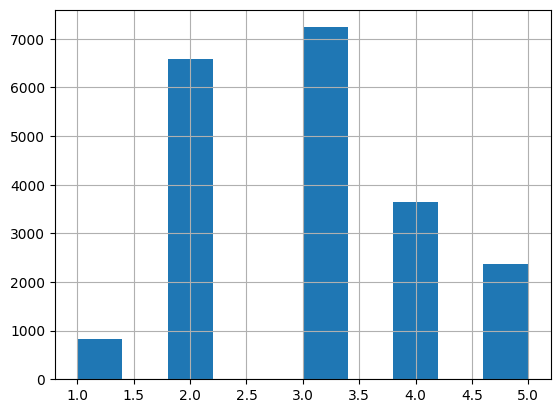

In [70]:
housing_df["income_cat"].hist()

In [71]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=7)

for train_index, test_index in split.split(housing_df, housing_df["income_cat"]):
    strat_train_set = housing_df.loc[train_index]
    strat_test_set = housing_df.loc[test_index]

In [72]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

,count
income_cat,
3,0.350533
2,0.318798
4,0.176357
5,0.114341
1,0.039971


In [73]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## Discover and Visualize the Data to Gain Insights

In [74]:
housing = strat_train_set.copy()

**Geographical graphs**

<Axes: xlabel='longitude', ylabel='latitude'>

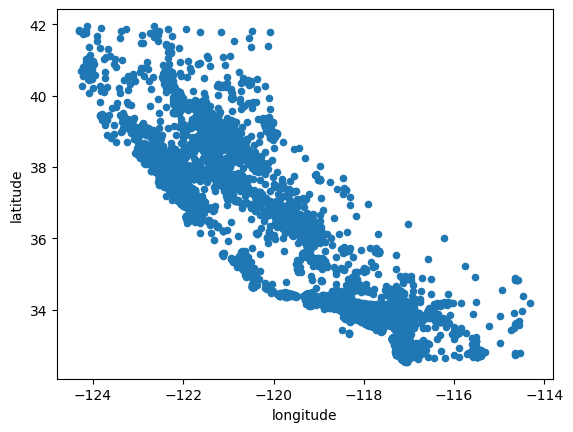

In [75]:
housing.plot(kind="scatter", x="longitude", y="latitude")

<Axes: xlabel='longitude', ylabel='latitude'>

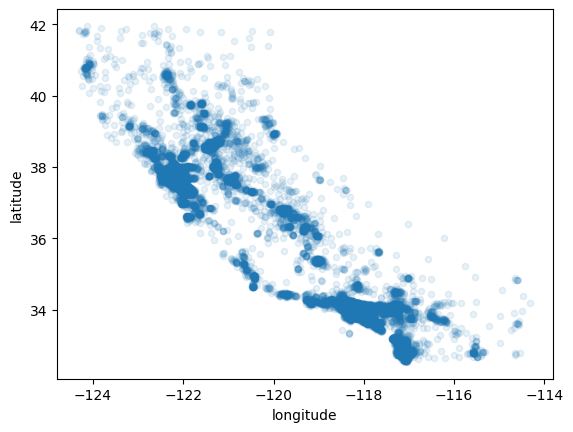

In [76]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

<Axes: xlabel='longitude', ylabel='latitude'>

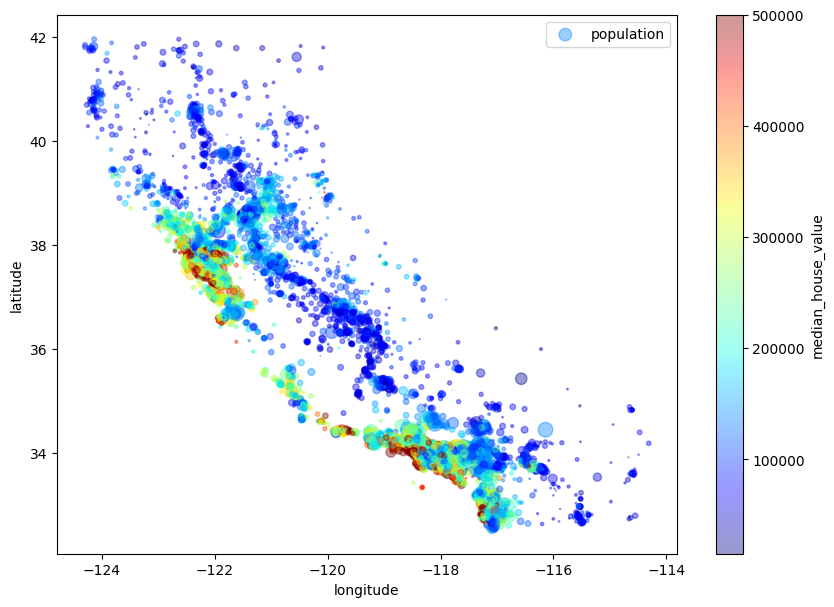

In [77]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population", figsize=(10, 7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)

**Look for correlations**

In [78]:
corr_matrix = housing.select_dtypes(include=[float, int]).corr()


In [79]:
corr_matrix["median_house_value"].sort_values(ascending=False)

,median_house_value
median_house_value,1.000000
median_income,0.686289
total_rooms,0.135723
housing_median_age,0.109030
households,0.066404
total_bedrooms,0.050819
population,-0.024405
longitude,-0.045513
latitude,-0.145896


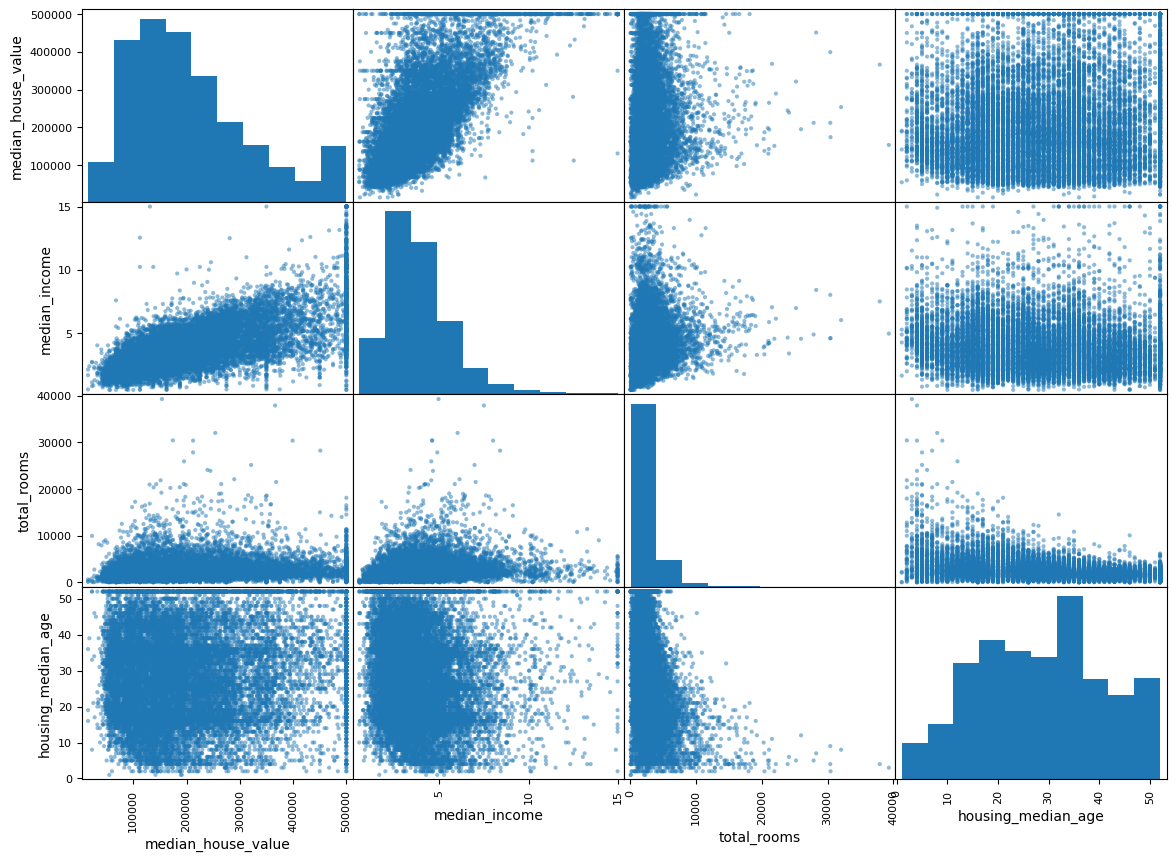

In [80]:
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]

scatter_matrix(housing[attributes], figsize=(14, 10))
plt.show()

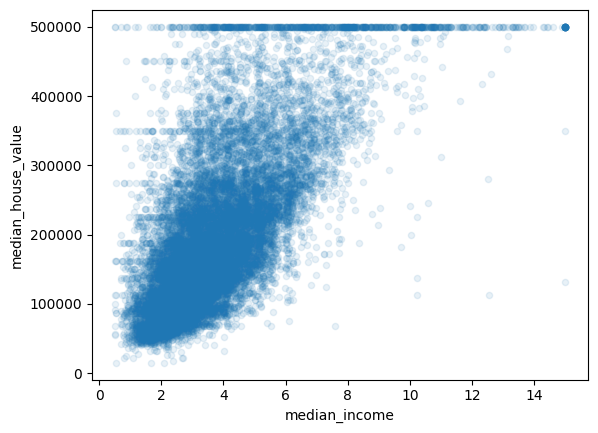

In [81]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)
plt.show()

**Experiment attribute combinations**

In [82]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

In [85]:
corr_matrix = housing.select_dtypes(include=[float, int]).corr()


In [86]:
corr_matrix["median_house_value"].sort_values(ascending=False)

,median_house_value
median_house_value,1.000000
median_income,0.686289
rooms_per_household,0.147401
total_rooms,0.135723
housing_median_age,0.109030
households,0.066404
total_bedrooms,0.050819
population_per_household,-0.021876
population,-0.024405
longitude,-0.045513


## Prepare the data for ML Algorithms

In [87]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

**Data Cleaning**

In [88]:
housing.dropna(subset=["total_bedrooms"]) # option 1
housing.drop("total_bedrooms", axis=1) # option 2
median = housing["total_bedrooms"].median() # option 3

housing["total_bedrooms"].fillna(median, inplace=True)

<ipython-input-88-3891427396>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  housing["total_bedrooms"].fillna(median, inplace=True)


In [89]:
imputer = SimpleImputer(strategy="median")

In [90]:
housing_num = housing.drop("ocean_proximity", axis=1)

In [91]:
housing_num.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
8088,-118.21,33.82,34.0,1719.0,398.0,1444.0,372.0,2.8438
15259,-117.27,33.03,25.0,1787.0,311.0,1108.0,311.0,3.9826
710,-122.08,37.68,26.0,1167.0,370.0,253.0,137.0,2.4196
12828,-121.45,38.70,24.0,2159.0,369.0,1141.0,355.0,3.9853
18294,-122.10,37.39,35.0,2471.0,349.0,881.0,342.0,7.6229


In [92]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [93]:
imputer.statistics_

array([-118.5    ,   34.26   ,   29.     , 2125.     ,  435.     ,
       1166.5    ,  409.     ,    3.53715])

In [94]:
housing_num.median().values

array([-118.5    ,   34.26   ,   29.     , 2125.     ,  435.     ,
       1166.5    ,  409.     ,    3.53715])

In [95]:
X = imputer.transform(housing_num)

In [96]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
8088,-118.21,33.82,34.0,1719.0,398.0,1444.0,372.0,2.8438
15259,-117.27,33.03,25.0,1787.0,311.0,1108.0,311.0,3.9826
710,-122.08,37.68,26.0,1167.0,370.0,253.0,137.0,2.4196
12828,-121.45,38.70,24.0,2159.0,369.0,1141.0,355.0,3.9853
18294,-122.10,37.39,35.0,2471.0,349.0,881.0,342.0,7.6229


## Handling Text and Categorical Attributes

In [97]:
housing_cat = housing[["ocean_proximity"]]

housing_cat.head()

,ocean_proximity
8088,NEAR OCEAN
15259,NEAR OCEAN
710,NEAR BAY
12828,INLAND
18294,NEAR BAY


In [98]:
ordinal_encoder = OrdinalEncoder()

housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

housing_cat_encoded[:5]

array([[4.],
       [4.],
       [3.],
       [1.],
       [3.]])

In [99]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [100]:
cat_encoder = OneHotEncoder()

housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

housing_cat_1hot

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16512 stored elements and shape (16512, 5)>

In [101]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

## Custom Transformers

In [102]:
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributeAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kwargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]

        if (self.add_bedrooms_per_room):
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_(X, rooms_per_household, population_per_household,
                         bedrooms_per_room)
        return np.c_[X, rooms_per_household, population_per_household]

In [103]:
attr_adder = CombinedAttributeAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

## Transformation Pipeline

In [104]:
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("attribs_adder", CombinedAttributeAdder(add_bedrooms_per_room=False)),
    ("std_scaler", StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [105]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
8088,-118.21,33.82,34.0,1719.0,398.0,1444.0,372.0,2.8438,NEAR OCEAN
15259,-117.27,33.03,25.0,1787.0,311.0,1108.0,311.0,3.9826,NEAR OCEAN
710,-122.08,37.68,26.0,1167.0,370.0,253.0,137.0,2.4196,NEAR BAY
12828,-121.45,38.70,24.0,2159.0,369.0,1141.0,355.0,3.9853,INLAND
18294,-122.10,37.39,35.0,2471.0,349.0,881.0,342.0,7.6229,NEAR BAY


In [106]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing)

# Selected and Train a Model

### Using Linear Regression Algorithms

In [107]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [108]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print(f"Predictions: {lin_reg.predict(some_data_prepared)}")
print(f"Labels: {list(some_labels)}")

Predictions: [183296.2700776  217303.20434967 189139.40854917 140555.75473093
 387630.11947135]
Labels: [139300.0, 215800.0, 275000.0, 90400.0, 500001.0]


In [109]:
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

np.float64(68306.45468762996)

## Using Decision Tree Algorithms

In [110]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [111]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

np.float64(0.0)

## Using K-fold cross validation

In [112]:
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scored = np.sqrt(-scores)

In [113]:
def display_scores(scores):
    print(f"Scores: {scores}")
    print(f"Mean: {scores.mean()}")
    print(f"Standard Deviation: {scores.std()}")

In [114]:
display_scores(tree_rmse_scored)

Scores: [69352.09984611 70504.22012284 73073.41212579 69653.65917091
 67294.05810054 70668.11621999 73739.21274151 73279.82876186
 72866.27653126 72496.71213777]
Mean: 71292.75957585897
Standard Deviation: 2012.067482203733


In [115]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [67982.21481055 64916.84179865 67663.58158155 69840.29357413
 68861.25183523 66759.29899158 71668.7008457  72227.86817392
 68569.8192162  66272.65462753]
Mean: 68476.25254550629
Standard Deviation: 2183.154108395341


### Using Random Forest Algorithm

In [116]:
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor()

In [117]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

np.float64(18715.155623759474)

In [118]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [48668.35179515 47489.68316368 49401.79293201 51372.63033041
 50343.43642976 49729.30521542 53245.57423546 52551.16667803
 51225.41079974 50341.75230704]
Mean: 50436.910388667966
Standard Deviation: 1651.0569479940773


**save the model**

In [120]:
#joblib.dump(forest_reg, "reports/models/forest_regressor.pkl")

**load the model**

In [121]:
#forest_reg = joblib.load("reports/models/forest_regressor.pkl")

### Using Ridge Algorithm

In [122]:
ridge_reg = Ridge()
ridge_reg.fit(housing_prepared, housing_labels)

Ridge()

In [123]:
housing_predictions = ridge_reg.predict(housing_prepared)
ridge_mse = mean_squared_error(housing_labels, housing_predictions)
ridge_rmse = np.sqrt(ridge_mse)
ridge_rmse

np.float64(68307.57146670665)

In [124]:
ridge_scores = cross_val_score(ridge_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
ridge_rmse_scores = np.sqrt(-ridge_scores)
display_scores(ridge_rmse_scores)

Scores: [67945.64319828 64918.79263188 67663.63526504 69838.28153132
 68868.31729411 66759.20077715 71667.53781342 72225.32151113
 68654.07675667 66272.97738278]
Mean: 68481.37841617699
Standard Deviation: 2183.5777654775243


### Using Support Vector Machine Algorithm

In [125]:
svr_reg = SVR()
svr_reg.fit(housing_prepared, housing_labels)

SVR()

In [126]:
housing_predictions = svr_reg.predict(housing_prepared)
svr_mse = mean_squared_error(housing_labels, housing_predictions)
svr_rmse = np.sqrt(svr_mse)
svr_rmse

np.float64(118115.73199642693)

In [127]:
svr_scores = cross_val_score(svr_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
svr_rmse_scores = np.sqrt(-svr_scores)
display_scores(svr_rmse_scores)

Scores: [118707.39340601 114122.7557943  119037.77783226 118372.58821844
 117762.60652311 123364.03066552 121216.27961538 120809.12094321
 111953.20779874 115811.5006657 ]
Mean: 118115.72614626514
Standard Deviation: 3240.8845768507076


**save the model**

In [129]:
#joblib.dump(svr_reg, "reports/models/svr_regressor.pkl")

**load the model**

In [130]:
#svr_reg = joblib.load("reports/models/svr_regressor.pkl")

### Using Neural Network Algorithm

In [131]:
mlp_reg = MLPRegressor()
mlp_reg.fit(housing_prepared, housing_labels)

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor()

In [132]:
housing_predictions = mlp_reg.predict(housing_prepared)
mlp_mse = mean_squared_error(housing_labels, housing_predictions)
mlp_rmse = np.sqrt(mlp_mse)
mlp_rmse

np.float64(169641.5894075765)

In [133]:
mlp_scores = cross_val_score(mlp_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
mlp_rmse_scores = np.sqrt(-mlp_scores)
display_scores(mlp_rmse_scores)

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

Scores: [175693.78911961 170594.73551275 179131.38274863 181167.97810816
 179960.07296856 181611.09983406 180143.63517222 181361.9739967
 171165.32015364 176110.44326961]
Mean: 177694.0430883933
Standard Deviation: 3919.1811498092047


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## Fine Tunning

### Grid Search for Random Forest Algorithm

In [134]:
param_grid = [
    {"n_estimators": [3, 10, 30],
     "max_features": [2, 4, 6, 8]},
    {"bootstrap": [False],
     "n_estimators": [3, 10],
     "max_features": [2, 3, 4]}
]
forest_reg = RandomForestRegressor()
grid_search_forest = GridSearchCV(forest_reg, param_grid, cv=5,
                                  scoring="neg_mean_squared_error",
                                  return_train_score=True)

grid_search_forest.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [135]:
grid_search_forest.best_params_

{'max_features': 6, 'n_estimators': 30}

In [136]:
grid_search_forest.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30)

In [137]:
cvres = grid_search_forest.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

61871.597550722625 {'max_features': 2, 'n_estimators': 3}
54957.15510483005 {'max_features': 2, 'n_estimators': 10}
52312.4883260439 {'max_features': 2, 'n_estimators': 30}
60642.78515043025 {'max_features': 4, 'n_estimators': 3}
52616.05559527225 {'max_features': 4, 'n_estimators': 10}
49993.11941987323 {'max_features': 4, 'n_estimators': 30}
58526.16173439636 {'max_features': 6, 'n_estimators': 3}
52325.20121654228 {'max_features': 6, 'n_estimators': 10}
49827.48380995671 {'max_features': 6, 'n_estimators': 30}
57568.79813715559 {'max_features': 8, 'n_estimators': 3}
52347.749162334265 {'max_features': 8, 'n_estimators': 10}
50143.74386351036 {'max_features': 8, 'n_estimators': 30}
60959.50046280277 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54124.647239445796 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59754.83644903936 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
51985.92681573098 {'bootstrap': False, 'max_features': 3, 'n_estimators': 

### Randomized Search CV Random Forest Algorithm

In [138]:
from re import S
rf_p_dist={
    'max_depth':[3,5,10,None],
    'n_estimators':[10,100,200,300,400,500],
    'max_features':randint(1,3),
    'bootstrap':[True,False],
    'min_samples_leaf':randint(1,4),
}

nbr_iter = 40

forest_reg = RandomForestRegressor()

rdmsearch = RandomizedSearchCV(forest_reg, param_distributions=rf_p_dist,
                               scoring="neg_mean_squared_error",
                                n_jobs=-1, n_iter=nbr_iter, cv=9)

rdmsearch.fit(housing_prepared, housing_labels)

ht_params = rdmsearch.best_params_
ht_score = rdmsearch.best_score_


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [139]:
ht_params

{'bootstrap': False,
 'max_depth': None,
 'max_features': 2,
 'min_samples_leaf': 1,
 'n_estimators': 100}

In [140]:
np.sqrt(-ht_score)

np.float64(50135.79974652742)

## Analyze the best Model and Their Errors

In [141]:
feature_importance = grid_search_forest.best_estimator_.feature_importances_
feature_importance

array([0.08649444, 0.07793995, 0.04370432, 0.01929748, 0.01835646,
       0.01934663, 0.01768044, 0.33382689, 0.0885054 , 0.10631863,
       0.01108328, 0.16874571, 0.00034216, 0.00379119, 0.00456703])

In [142]:
extra_attribs = ["rooms_per_hold", "pop_per_hold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs

sorted(zip(feature_importance, attributes), reverse=True)

[(np.float64(0.3338268908377954), 'median_income'),
 (np.float64(0.168745709639053), '<1H OCEAN'),
 (np.float64(0.10631863189904163), 'pop_per_hold'),
 (np.float64(0.088505401287234), 'rooms_per_hold'),
 (np.float64(0.08649443646607223), 'longitude'),
 (np.float64(0.0779399517844455), 'latitude'),
 (np.float64(0.043704315866666496), 'housing_median_age'),
 (np.float64(0.019346628133844117), 'population'),
 (np.float64(0.01929748490349053), 'total_rooms'),
 (np.float64(0.018356457285511933), 'total_bedrooms'),
 (np.float64(0.017680440298903293), 'households'),
 (np.float64(0.011083277049762762), 'bedrooms_per_room'),
 (np.float64(0.004567029143300939), 'NEAR BAY'),
 (np.float64(0.003791188707169717), 'ISLAND'),
 (np.float64(0.0003421566977083164), 'INLAND')]

# Evaluate my Sytem on the Test Set

In [143]:
final_model = grid_search_forest.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"]

X_test_prepared = full_pipeline.transform(X_test)

In [144]:
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [145]:
confidence = 0.95

squared_errors = (final_predictions - y_test) ** 2

np.sqrt(stats.t.interval(confidence, len(squared_errors)-1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([45466.92548028, 49896.94918286])